In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import pandas as pd, numpy as np
from pathlib import Path
import os, sys, yaml

# use notebook path to find repo root, path to repo parent directory, and airflow dags repo
# note that the two repos must by subdirs in some common parent for this to work
nb_dpath = Path(os.path.abspath(""))
repo_dpath = nb_dpath.parent
# append airflow-dags projs path and emp_retention repo path to python path
sys.path.append(str(repo_dpath))

# local imports
from datasets.load_dsets import load_walmart_dset

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use(['dark_background'])

# walmart csv
- 143 weeks starting from Feb 2010 and ending on Oct 2012 (let's make the treatment period start on `'2012-09-07'` )
    - 8 weeks, 2 months (pretty long experiment)
- 45 stores
    - no missing weeks for any
- distribution notes
    - seems uniformly distributed at the moment, 
    - later, let's make a pareto distributed column (this way we can have some heterogenous splitting issues to play with)

### LOad the dset and add pareto sales column

In [8]:
# download and format
df = load_walmart_dset(pareto=True)

# print some stats
display(df.shape)
display(df.head(2))
display(df[['weekly_sales','pareto_sales']].describe())

(6435, 9)

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,pareto_sales
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,142178.13
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,142478.49


,weekly_sales,pareto_sales
count,6.435000e+03,6.435000e+03
mean,1.046965e+06,9.672588e+05
std,5.643666e+05,1.277846e+06
min,2.099862e+05,2.634178e+04
25%,5.533501e+05,1.904581e+05
50%,9.607460e+05,4.161557e+05
75%,1.420159e+06,1.254509e+06
max,3.818686e+06,8.711469e+06


### Visualize the time series

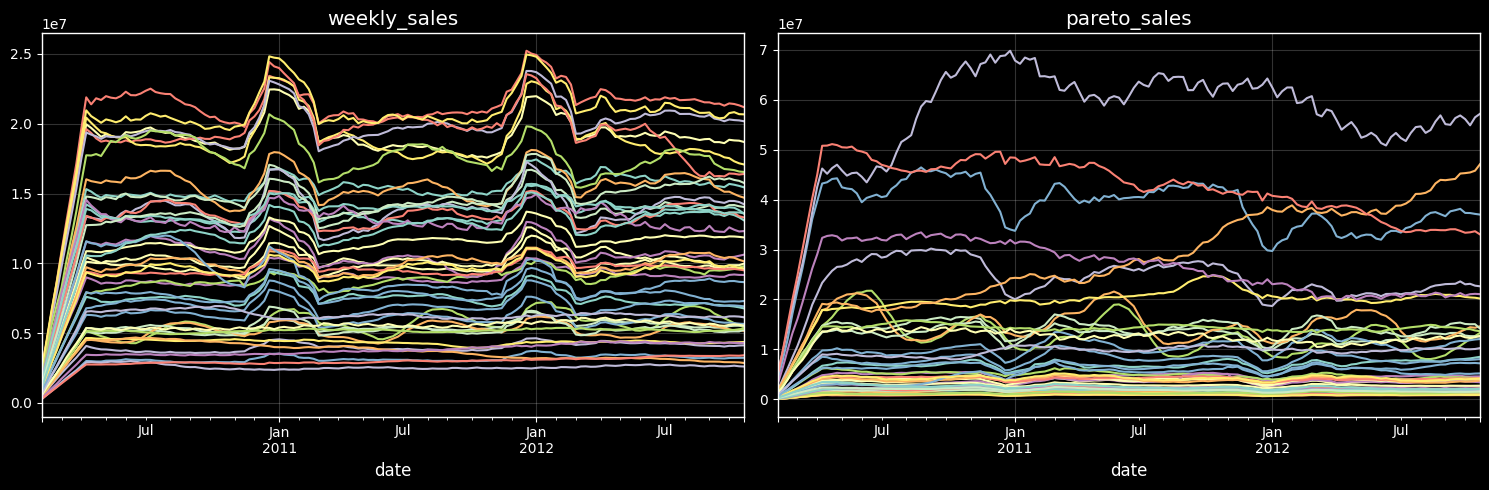

In [9]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
temp_df = df.set_index(['store','date'])

for ax, sales_col in zip(axes,['weekly_sales','pareto_sales']):
    for store in range(1,46):
        temp_df.loc[store, sales_col].rolling(10,1).sum().plot(ax=ax)
    ax.set_title(sales_col); ax.grid(alpha=0.2)
plt.tight_layout()

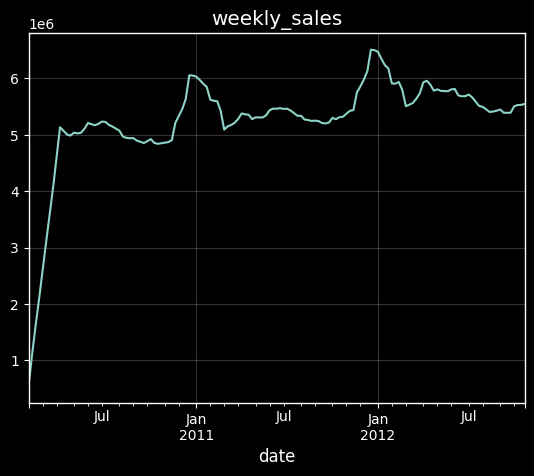

In [44]:
store_id = 9
sales_col = 'weekly_sales'
temp_df = df.set_index(['store','date']).loc[store_id]

temp_df[sales_col].rolling(10,1).sum().plot()
ax = plt.gca(); ax.set_title(sales_col); ax.grid(alpha=0.2)

In [45]:
temp_df

,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,pareto_sales
date,,,,,,,
2010-02-05,549505.55,0,38.01,2.572,214.655459,6.415,1272122.49
2010-02-12,552677.48,1,37.08,2.548,214.805653,6.415,1257562.44
2010-02-19,511327.90,0,43.06,2.514,214.850618,6.415,1469176.98
2010-02-26,473773.27,0,43.83,2.561,214.878045,6.415,1711323.00
2010-03-05,507297.88,0,48.43,2.625,214.905472,6.415,1492612.25
...,...,...,...,...,...,...,...
2012-09-28,516361.06,0,76.80,3.666,226.763073,5.277,1440675.36
2012-10-05,606755.30,0,66.61,3.617,226.966232,4.954,1043388.24
2012-10-12,558464.80,0,60.09,3.601,227.169392,4.954,1231633.48


In [37]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Optional, Tuple, Union

import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX


@dataclass
class SarimaxForecast:
    """Container for SARIMAX forecast outputs."""
    model_fit: object
    forecast: pd.DataFrame  # columns: yhat, lower, upper (+ optional se)


def fit_sarimax_with_intervals(
    y: Union[pd.Series, pd.DataFrame],
    exog: Optional[pd.DataFrame] = None,
    exog_future: Optional[pd.DataFrame] = None,
    *,
    order: Tuple[int, int, int] = (1, 1, 1),
    seasonal_order: Tuple[int, int, int, int] = (0, 0, 0, 0),
    trend: Optional[str] = None,
    steps: int = 8,
    alpha: float = 0.05,
    enforce_stationarity: bool = False,
    enforce_invertibility: bool = False,
) -> SarimaxForecast:
    """
    Fit a statsmodels SARIMAX and produce forecast + prediction intervals.

    Parameters
    ----------
    y
        Target time series, indexed by datetime-like or integer index.
        If DataFrame, must have exactly 1 column.
    exog
        Exogenous regressors aligned to y.index (same number of rows as y).
    exog_future
        Exogenous regressors for the forecast horizon; must have `steps` rows.
        If you pass exog during training, you *must* pass exog_future to forecast.
        If you did not use exog, leave this as None.
    order
        (p, d, q): AR order p, differencing d, MA order q.
    seasonal_order
        (P, D, Q, s): seasonal AR P, seasonal differencing D, seasonal MA Q,
        and seasonal period s (e.g., s=52 for weekly data with yearly seasonality).
    trend
        Trend term: None, 'n', 'c', 't', 'ct' (statsmodels convention).
    steps
        Forecast horizon (number of future periods).
    alpha
        Significance level for two-sided intervals.
        Example: alpha=0.05 => 95% prediction interval.
    enforce_stationarity / enforce_invertibility
        Often set False for robustness in retail series; can set True if desired.

    Returns
    -------
    SarimaxForecast
        model_fit: fitted SARIMAXResults
        forecast: DataFrame with yhat, lower, upper (and se)
    """
    # --- normalize y to a Series ---
    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("If `y` is a DataFrame it must have exactly 1 column.")
        y = y.iloc[:, 0]
    if not isinstance(y, pd.Series):
        raise TypeError("`y` must be a pandas Series or 1-col DataFrame.")

    y = y.astype(float)

    # --- basic input checks ---
    if exog is not None:
        if len(exog) != len(y):
            raise ValueError("`exog` must have the same number of rows as `y`.")
        # ensure aligned index (common gotcha)
        if not exog.index.equals(y.index):
            exog = exog.reindex(y.index)
            if exog.isnull().any().any():
                raise ValueError("`exog` could not be aligned to `y.index` cleanly.")

    if exog is None and exog_future is not None:
        raise ValueError("Provided `exog_future` but `exog` is None (training had no exog).")

    if exog is not None:
        if exog_future is None:
            raise ValueError("Training uses `exog`, so you must provide `exog_future`.")
        if len(exog_future) != steps:
            raise ValueError("`exog_future` must have exactly `steps` rows.")
        if list(exog_future.columns) != list(exog.columns):
            raise ValueError("`exog_future` columns must match `exog` columns exactly.")

    # --- build & fit model ---
    model = SARIMAX(
        endog=y,
        exog=exog,
        order=order,
        seasonal_order=seasonal_order,
        trend=trend,
        enforce_stationarity=enforce_stationarity,
        enforce_invertibility=enforce_invertibility,
    )

    # `disp=False` silences optimizer output
    res = model.fit(disp=False)

    # --- forecast with intervals ---
    fc = res.get_forecast(steps=steps, exog=exog_future)
    mean = fc.predicted_mean
    ci = fc.conf_int(alpha=alpha)

    # statsmodels names the CI columns like 'lower y'/'upper y' (or the y name)
    lower_col = [c for c in ci.columns if "lower" in c.lower()][0]
    upper_col = [c for c in ci.columns if "upper" in c.lower()][0]

    out = pd.DataFrame(
        {
            "yhat": mean,
            "lower": ci[lower_col],
            "upper": ci[upper_col],
            "se": fc.se_mean,
        }
    )

    return SarimaxForecast(model_fit=res, forecast=out)


In [38]:
temp_df

,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,pareto_sales
date,,,,,,,
2010-02-05,549505.55,0,38.01,2.572,214.655459,6.415,1272122.49
2010-02-12,552677.48,1,37.08,2.548,214.805653,6.415,1257562.44
2010-02-19,511327.90,0,43.06,2.514,214.850618,6.415,1469176.98
2010-02-26,473773.27,0,43.83,2.561,214.878045,6.415,1711323.00
2010-03-05,507297.88,0,48.43,2.625,214.905472,6.415,1492612.25
...,...,...,...,...,...,...,...
2012-09-28,516361.06,0,76.80,3.666,226.763073,5.277,1440675.36
2012-10-05,606755.30,0,66.61,3.617,226.966232,4.954,1043388.24
2012-10-12,558464.80,0,60.09,3.601,227.169392,4.954,1231633.48


In [72]:
predict_steps = 70

y = temp_df["weekly_sales"].iloc[:-predict_steps]
exog_train = temp_df[["holiday_flag"]].iloc[:-predict_steps]
exog_future = temp_df[["holiday_flag"]].iloc[-predict_steps:]

res = fit_sarimax_with_intervals(
    y=y,
    exog=exog_train,
    exog_future=exog_future,
    order=(1, 1, 1),
    seasonal_order=(1, 0, 0, 52),  # or (0, 0, 0, 0)
    trend=None,
    steps=predict_steps,
    alpha=0.05,
)

res.forecast.head()

/home/sfronczak/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/home/sfronczak/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


,yhat,lower,upper,se
2011-07-01,555911.072350,428618.943768,683203.200931,64946.156963
2011-07-08,529808.588857,399678.433019,659938.744694,66394.156660
2011-07-15,523612.787191,384585.661260,662639.913122,70933.510528
2011-07-22,517070.769956,371202.019294,662939.520618,74424.199533
2011-07-29,520507.746842,367797.970502,673217.523182,77914.582892


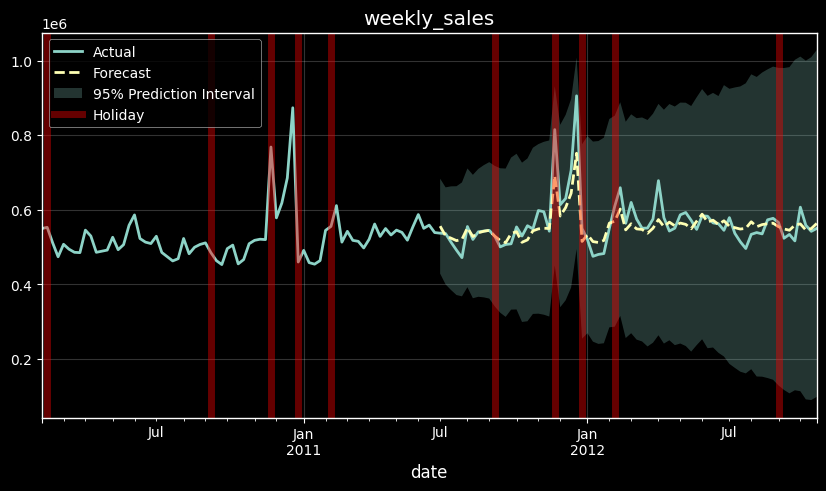

In [77]:
fig, ax = plt.subplots(figsize=(10, 5))

# Historical data
temp_df[sales_col].plot(ax=ax, label="Actual", linewidth=2)

# Forecast mean
res.forecast["yhat"].plot(
    ax=ax,
    label="Forecast",
    linewidth=2,
    linestyle="--"
)

# Confidence / prediction interval
ax.fill_between(
    res.forecast.index,
    res.forecast["lower"],
    res.forecast["upper"],
    alpha=0.25,
    label="95% Prediction Interval"
)

# --- holiday vertical lines (train + future) ---
holiday_idx = temp_df.index[temp_df["holiday_flag"] == 1]

for i, dt in enumerate(holiday_idx):
    ax.axvline(
        x=dt,
        linestyle="-",
        alpha=0.4,
        linewidth=5,
        c='r',
        label="Holiday" if i == 0 else None,  # avoid legend spam
    )

ax.set_title(sales_col)
ax.grid(alpha=0.2)
ax.legend(loc=2)

https://zerotomastery.io/blog/arima-sarima-sarimax-explained/

- remind myself of how each component works (for example, what is the seasonal order stuff)

- figure out eval metric
- grid search over some different order combinations
- does it learn more from seasonal things or exog indicators? (remove each and see results - how to turn them off)

In [75]:
exog_future.head(30)

,holiday_flag
date,
2011-07-01,0
2011-07-08,0
2011-07-15,0
2011-07-22,0
2011-07-29,0
2011-08-05,0
2011-08-12,0
2011-08-19,0
2011-08-26,0
